In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import json
import matplotlib.pyplot as plt

In [2]:
os.listdir("data/data")

['node_cpu_seconds_total_2024-02-04 15:40:12.798404.csv',
 'kepler_node_other_joules_total_2024-02-04 15:59:45.505481.csv',
 'kepler_container_bpf_cpu_time_us_total_2024-02-04 15:59:49.113448.csv',
 'kepler_node_core_joules_total_2024-02-04 15:37:39.199998.csv',
 'kepler_node_dram_joules_total_2024-02-04 15:59:43.534934.csv',
 'kepler_container_joules_total_2024-02-04 15:59:33.297411.csv',
 'kepler_node_platform_joules_total_2024-02-04 15:59:45.295419.csv',
 'kepler_node_package_joules_total_2024-02-04 15:59:44.603020.csv']

In [3]:
data_folder = "data/data/"
cpu_util_file = "node_cpu_seconds_total_2024-02-04 15:40:12.798404.csv"
node_package_power_file = "kepler_node_package_joules_total_2024-02-04 15:59:44.603020.csv"
node_dram_power_file = "kepler_node_dram_joules_total_2024-02-04 15:59:43.534934.csv"

In [4]:
cpu_util = pd.read_csv(data_folder+cpu_util_file)
cpu_util = cpu_util[cpu_util['mode']!='idle']
cpu_util_agg = cpu_util.groupby(['instance', 'timestamp'], as_index=False)['value'].sum()
cpu_util_agg['timestamp'] = pd.to_datetime(cpu_util_agg['timestamp'])

node_package_power = pd.read_csv(data_folder+node_package_power_file)
node_package_power = node_package_power.groupby(['instance', 'timestamp'], as_index=False)['value'].sum()
node_package_power['timestamp'] = pd.to_datetime(node_package_power['timestamp'])

node_dram_power = pd.read_csv(data_folder+node_dram_power_file)
node_dram_power = node_dram_power.groupby(['instance', 'timestamp'], as_index=False)['value'].sum()
node_dram_power['timestamp'] = pd.to_datetime(node_dram_power['timestamp'])

In [5]:
node_power_metrics = pd.merge(node_package_power, node_dram_power, on = ["timestamp", "instance"])
node_power_metrics = node_power_metrics.rename(columns={"value_x":"package", "value_y":"dram"})
node_power_metrics['power'] = node_power_metrics['package'] + node_power_metrics['dram']

In [6]:
import model

Node :  kube-worker-171


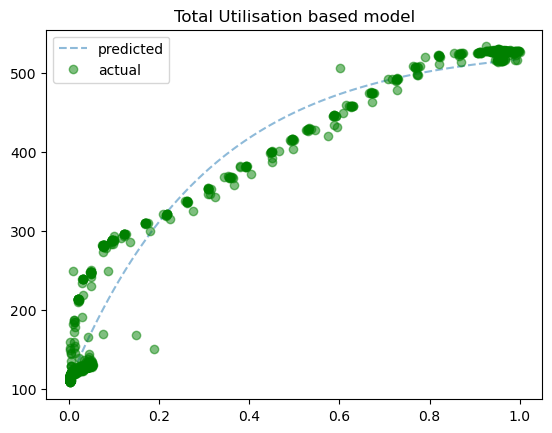

Node :  kube-worker-68


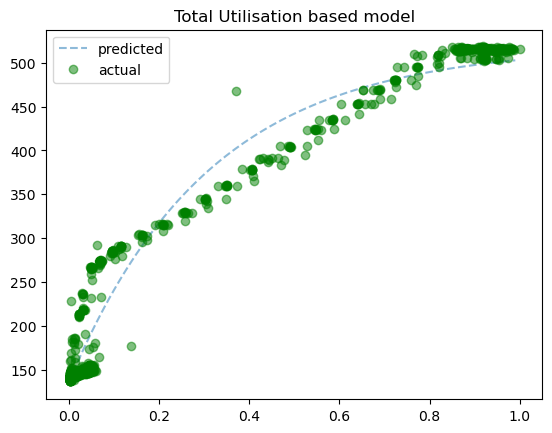

In [7]:
node_power_models = {}
for node in cpu_util_agg['instance'].unique():
    if node == 'kube-master-90':
        continue
    print("Node : ", node)
    cpu = cpu_util_agg[cpu_util_agg['instance']==node]
    power = node_power_metrics[node_power_metrics['instance']==node]
    data = pd.merge_asof(cpu, power, on = 'timestamp')
    data.rename(columns={'value':'util'}, inplace=True)
    data.sort_values('timestamp', inplace=True)
    m = model.UtilisationPowerModel()
    
    node_df = data
    node_df['util'] = node_df['util'].diff()
    node_df['energy'] = node_df['power'].diff()
    node_df.fillna(0, inplace=True)

    node_df = node_df.iloc[2000: , :]

    node_df = node_df[(node_df[['util']] != 0).all(axis=1)]
    node_df = node_df[(node_df[['energy']] != 0).all(axis=1)]
    max_util = max(node_df['util'])
    node_df['util'] = node_df['util']/max_util

    node_df['power'] = node_df['energy']/30
    node_df['power'].fillna(node_df['power'].mean(), inplace=True)
    node_power_models[node] = m.get_model(node_df[['util', 'power']])

In [8]:
for node in node_power_models:
    print(node,node_power_models[node][2])

kube-worker-171 (tensor(533.1113, requires_grad=True), tensor(-425.1653, requires_grad=True), tensor(-3.2518, requires_grad=True))
kube-worker-68 (tensor(518.7468, requires_grad=True), tensor(-383.5057, requires_grad=True), tensor(-3.2190, requires_grad=True))


In [9]:
def get_power(k0, k1, k2, util):
    return k0+k1*np.exp(k2*util)

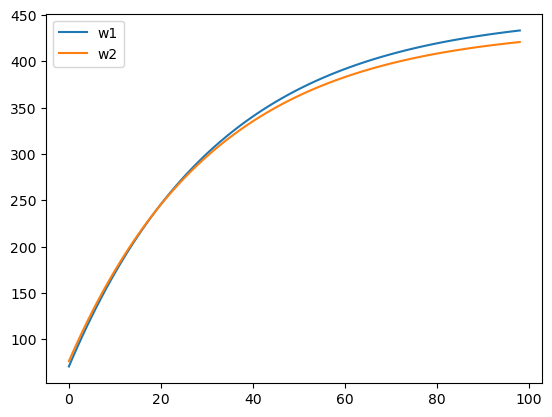

In [10]:
w1 = [get_power(452.1697, -393.5067, -3.0743, i/100) for i in range(1,100)]
w2 = [get_power(437.1473, -372.5006, -3.1656, i/100) for i in range(1,100)]
plt.plot(w1)
plt.plot(w2)
plt.legend(["w1","w2"])